## Import the packages

In [1]:
import os, random, json, PIL, shutil, re, imageio, glob
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import ImageDraw
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from tensorflow.keras import Model, losses, optimizers
from tensorflow.keras.callbacks import Callback


def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
SEED = 0
seed_everything(SEED)

2022-03-22 23:51:09.076919: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-03-22 23:51:09.077032: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Check TPU Configuration

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()


REPLICAS = strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE
print(f'REPLICAS: {REPLICAS}')

Running on TPU grpc://10.0.0.2:8470


2022-03-22 23:51:13.607316: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-22 23:51:13.610490: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-03-22 23:51:13.610531: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-22 23:51:13.610564: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f0d80f9c63cd): /proc/driver/nvidia/version does not exist
2022-03-22 23:51:13.613380: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

REPLICAS: 8


## Model Parameters

In [3]:
HEIGHT = 256
WIDTH = 256
HEIGHT_RESIZE = 128
WIDTH_RESIZE = 128
CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 120
TRANSFORMER_BLOCKS = 6
GENERATOR_LR = 2e-4
DISCRIMINATOR_LR = 2e-4

## Getting Data from Different Sources

In [4]:
GCS_PATH1 = KaggleDatasets().get_gcs_path('monet-tfrecords-256x256')
GCS_PATH2 = KaggleDatasets().get_gcs_path('gan-getting-started')

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH1 + '/*.tfrec'))
PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH2 + '/photo_tfrec/*.tfrec'))

2022-03-22 23:51:20.645679: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-03-22 23:51:20.723530: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [5]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

n_monet_samples = count_data_items(MONET_FILENAMES)
n_photo_samples = count_data_items(PHOTO_FILENAMES)

print(f'Monet TFRecord files: {len(MONET_FILENAMES)}')
print(f'Monet image files: {n_monet_samples}')
print(f'Photo TFRecord files: {len(PHOTO_FILENAMES)}')
print(f'Photo image files: {n_photo_samples}')

Monet TFRecord files: 5
Monet image files: 1367
Photo TFRecord files: 20
Photo image files: 7038


## Data Augmentation with Rotations, Flips, and Random Crops

Data augmentation for GANs should be handled with cautions, since it is directly related to style transfer, if we apply transformations that can change too much the style of the data (e.g. brightness, contrast, saturation) it can cause the generator to do not efficiently learn the base style, so in this case, we are using only spatial transformations like, flips, rotates and crops.

In [6]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    
    # 90º rotations
    if p_rotate > .8:
        image = tf.image.rot90(image, k=3) # rotate 270º
    elif p_rotate > .6:
        image = tf.image.rot90(image, k=2) # rotate 180º
    elif p_rotate > .4:
        image = tf.image.rot90(image, k=1) # rotate 90º
        
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)
                    
    # Train on crops
    image = tf.image.random_crop(image, size=[HEIGHT_RESIZE, WIDTH_RESIZE, CHANNELS])
          
    return image

## Helper Functions

In [7]:
def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        'image':      tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_dataset(filenames, augment=None, repeat=True, shuffle=True, batch_size=1):
    dataset = load_dataset(filenames)

    if augment:
        dataset = dataset.map(augment, num_parallel_calls=AUTO)
    dataset = dataset.map(normalize_img, num_parallel_calls=AUTO)
    if repeat:
        dataset = dataset.repeat()
    if shuffle:
        dataset = dataset.shuffle(512)
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    
    return dataset

def display_samples(ds, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        plt.subplot(121)
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()
        
def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)
        
        f = plt.figure(figsize=(12, 12))
        
        plt.subplot(121)
        plt.title('Input image')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title('Generated image')
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()
        
def evaluate_cycle(ds, generator_a, generator_b, n_samples=1):
    fig, axes = plt.subplots(n_samples, 3, figsize=(22, (n_samples*6)))
    axes = axes.flatten()
    
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        idx = n_sample*3
        example_sample = next(ds_iter)
        generated_a_sample = generator_a.predict(example_sample)
        generated_b_sample = generator_b.predict(generated_a_sample)
        
        axes[idx].set_title('Input image', fontsize=18)
        axes[idx].imshow(example_sample[0] * 0.5 + 0.5)
        axes[idx].axis('off')
        
        axes[idx+1].set_title('Generated image', fontsize=18)
        axes[idx+1].imshow(generated_a_sample[0] * 0.5 + 0.5)
        axes[idx+1].axis('off')
        
        axes[idx+2].set_title('Cycled image', fontsize=18)
        axes[idx+2].imshow(generated_b_sample[0] * 0.5 + 0.5)
        axes[idx+2].axis('off')
        
    plt.show()

def create_gif(images_path, gif_path):
    images = []
    filenames = glob.glob(images_path)
    filenames.sort(key=lambda x: int(''.join(filter(str.isdigit, x))))
    for epoch, filename in enumerate(filenames):
        img = PIL.ImageDraw.Image.open(filename)
        ImageDraw.Draw(img).text((0, 0),  # Coordinates
                                 f'Epoch {epoch+1}')
        images.append(img)
    imageio.mimsave(gif_path, images, fps=2) # Save gif
        
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make predition
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

## Auxiliar Model Functions 

* Encoder block: Apply convolutional filters while also reducing data resolution and increasing features.
* Decoder block: Apply convolutional filters while also increasing data resolution and decreasing features.
* Transformer block: Apply convolutional filters to find relevant data patterns and keeps features constant.

In [8]:
conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
def encoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, activation=L.ReLU(), name='block_x'):
    block = L.Conv2D(filters, size, 
                     strides=strides, 
                     padding='same', 
                     use_bias=False, 
                     kernel_initializer=conv_initializer, 
                     name=f'encoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
        
    block = activation(block)

    return block

def transformer_block(input_layer, size=3, strides=1, name='block_x'):
    filters = input_layer.shape[-1]
    
    block = L.Conv2D(filters, size, strides=strides, padding='same', use_bias=False, 
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_1')(input_layer)
#     block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
    block = L.ReLU()(block)
    
    block = L.Conv2D(filters, size, strides=strides, padding='same', use_bias=False, 
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_2')(block)
#     block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
    
    block = L.Add()([block, input_layer])

    return block

def decoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, name='block_x'):
    block = L.Conv2DTranspose(filters, size, 
                              strides=strides, 
                              padding='same', 
                              use_bias=False, 
                              kernel_initializer=conv_initializer, 
                              name=f'decoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = L.ReLU()(block)
    
    return block

# Resized convolution
def decoder_rc_block(input_layer, filters, size=3, strides=1, apply_instancenorm=True, name='block_x'):
    block = tf.image.resize(images=input_layer, method='bilinear', 
                            size=(input_layer.shape[1]*2, input_layer.shape[2]*2))
    
#     block = tf.pad(block, [[0, 0], [1, 1], [1, 1], [0, 0]], "SYMMETRIC") # Works only with GPU
#     block = L.Conv2D(filters, size, strides=strides, padding='valid', use_bias=False, # Works only with GPU
    block = L.Conv2D(filters, size, 
                     strides=strides, 
                     padding='same', 
                     use_bias=False, 
                     kernel_initializer=conv_initializer, 
                     name=f'decoder_{name}')(block)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = L.ReLU()(block)
    
    return block

## Data Observation

In [9]:
monet_ds = get_dataset(MONET_FILENAMES, augment=data_augment, batch_size=BATCH_SIZE)
photo_ds = get_dataset(PHOTO_FILENAMES, augment=data_augment, batch_size=BATCH_SIZE)
gan_ds = tf.data.Dataset.zip((monet_ds, photo_ds))

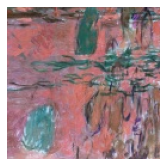

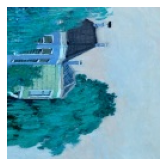

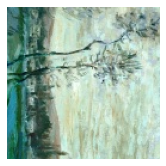

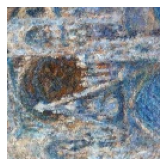

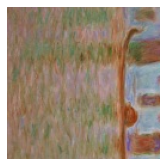

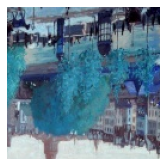

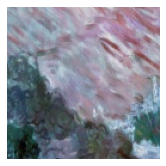

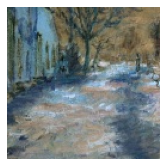

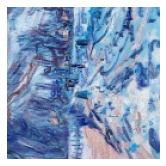

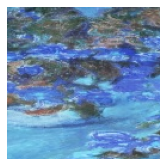

In [10]:
display_samples(monet_ds, 10)

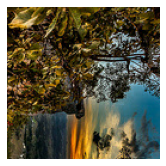

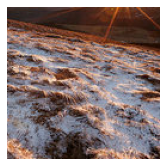

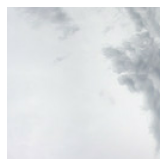

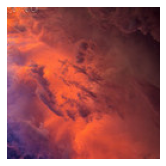

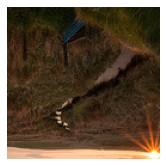

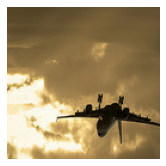

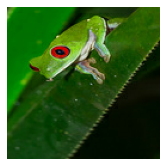

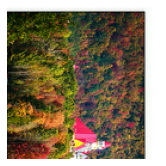

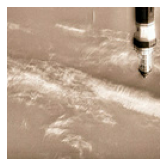

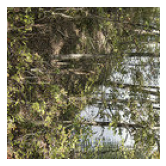

In [11]:
display_samples(photo_ds, 10)

## Generator

The generator is responsible for generating images from a specific domain. CycleGAN architecture has two generators, in this context we will have one generator that will take photos and generate Monet paints, and the other generator will take Monet paintings and generate photos.

In [12]:
def generator_fn(height=HEIGHT, width=WIDTH, channels=CHANNELS, transformer_blocks=TRANSFORMER_BLOCKS):
    OUTPUT_CHANNELS = 3
    inputs = L.Input(shape=[height, width, channels], name='input_image')

    # Encoder
    enc_1 = encoder_block(inputs, 64,  7, 1, apply_instancenorm=False, activation=L.ReLU(), name='block_1') # (bs, 256, 256, 64)
    enc_2 = encoder_block(enc_1, 128, 3, 2, apply_instancenorm=True, activation=L.ReLU(), name='block_2')   # (bs, 128, 128, 128)
    enc_3 = encoder_block(enc_2, 256, 3, 2, apply_instancenorm=True, activation=L.ReLU(), name='block_3')   # (bs, 64, 64, 256)
    
    # Transformer
    x = enc_3
    for n in range(transformer_blocks):
        x = transformer_block(x, 3, 1, name=f'block_{n+1}') # (bs, 64, 64, 256)

    # Decoder
    x_skip = L.Concatenate(name='enc_dec_skip_1')([x, enc_3]) # encoder - decoder skip connection
    
    dec_1 = decoder_block(x_skip, 128, 3, 2, apply_instancenorm=True, name='block_1') # (bs, 128, 128, 128)
    x_skip = L.Concatenate(name='enc_dec_skip_2')([dec_1, enc_2]) # encoder - decoder skip connection
    
    dec_2 = decoder_block(x_skip, 64,  3, 2, apply_instancenorm=True, name='block_2') # (bs, 256, 256, 64)
    x_skip = L.Concatenate(name='enc_dec_skip_3')([dec_2, enc_1]) # encoder - decoder skip connection

    outputs = last = L.Conv2D(OUTPUT_CHANNELS, 7, 
                              strides=1, padding='same', 
                              kernel_initializer=conv_initializer, 
                              use_bias=False, 
                              activation='tanh', 
                              name='decoder_output_block')(x_skip) # (bs, 256, 256, 3)

    generator = Model(inputs, outputs)
    
    return generator

## Discriminator

The discriminator is responsible for differentiating real images from images that have been generated by a generator model.

In [13]:
def discriminator_fn(height=HEIGHT, width=WIDTH, channels=CHANNELS):
    inputs = L.Input(shape=[height, width, channels], name='input_image')
    #inputs_patch = L.experimental.preprocessing.RandomCrop(height=70, width=70, name='input_image_patch')(inputs) # Works only with GPU

    # Encoder    
    x = encoder_block(inputs, 64,  4, 2, apply_instancenorm=False, activation=L.LeakyReLU(0.2), name='block_1') # (bs, 128, 128, 64)
    x = encoder_block(x, 128, 4, 2, apply_instancenorm=True, activation=L.LeakyReLU(0.2), name='block_2')       # (bs, 64, 64, 128)
    x = encoder_block(x, 256, 4, 2, apply_instancenorm=True, activation=L.LeakyReLU(0.2), name='block_3')       # (bs, 32, 32, 256)
    x = encoder_block(x, 512, 4, 1, apply_instancenorm=True, activation=L.LeakyReLU(0.2), name='block_4')       # (bs, 32, 32, 512)

    outputs = L.Conv2D(1, 4, strides=1, padding='valid', kernel_initializer=conv_initializer)(x)                # (bs, 29, 29, 1)
    
    discriminator = Model(inputs, outputs)
    
    return discriminator

## CycleGAN

The benefit of the CycleGAN model is that it can be trained without paired examples. That is, it does not require examples of photographs before and after the translation in order to train the model, e.g. photos of the same city landscape during the day and at night. Instead, the model is able to use a collection of photographs from each domain and extract and harness the underlying style of images in the collection in order to perform the translation.

The model architecture is comprised of two generator models: one generator (Generator-A) for generating images for the first domain (Domain-A) and the second generator (Generator-B) for generating images for the second domain (Domain-B).

* Generator-A -> Domain-A
* Generator-B -> Domain-B

The generator models perform image translation, meaning that the image generation process is conditional on an input image, specifically an image from the other domain. Generator-A takes an image from Domain-B as input and Generator-B takes an image from Domain-A as input.

* Domain-B -> Generator-A -> Domain-A
* Domain-A -> Generator-B -> Domain-B

Each generator has a corresponding discriminator model. The first discriminator model (Discriminator-A) takes real images from Domain-A and generated images from Generator-A and predicts whether they are real or fake. The second discriminator model (Discriminator-B) takes real images from Domain-B and generated images from Generator-B and predicts whether they are real or fake.

* Domain-A -> Discriminator-A -> [Real/Fake]
* Domain-B -> Generator-A -> Discriminator-A -> [Real/Fake]
* Domain-B -> Discriminator-B -> [Real/Fake]
* Domain-A -> Generator-B -> Discriminator-B -> [Real/Fake]

In [14]:
with strategy.scope():
    monet_generator = generator_fn(height=None, width=None, transformer_blocks=TRANSFORMER_BLOCKS) # transforms photos to Monet-esque paintings
    photo_generator = generator_fn(height=None, width=None, transformer_blocks=TRANSFORMER_BLOCKS) # transforms Monet paintings to be more like photos

    monet_discriminator = discriminator_fn(height=None, width=None) # differentiates real Monet paintings and generated Monet paintings
    photo_discriminator = discriminator_fn(height=None, width=None) # differentiates real photos and generated photos


class CycleGan(Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {'monet_gen_loss': total_monet_gen_loss,
                'photo_gen_loss': total_photo_gen_loss,
                'monet_disc_loss': monet_disc_loss,
                'photo_disc_loss': photo_disc_loss
               }

## Loss Function

In [15]:
with strategy.scope():
    # Discriminator loss {0: fake, 1: real} (The discriminator loss outputs the average of the real and generated loss)
    def discriminator_loss(real, generated):
        real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5
    
    # Generator loss
    def generator_loss(generated):
        return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    
    # Cycle consistency loss (measures if original photo and the twice transformed photo to be similar to one another)
    with strategy.scope():
        def calc_cycle_loss(real_image, cycled_image, LAMBDA):
            loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

            return LAMBDA * loss1

    # Identity loss (compares the image with its generator (i.e. photo with photo generator))
    with strategy.scope():
        def identity_loss(real_image, same_image, LAMBDA):
            loss = tf.reduce_mean(tf.abs(real_image - same_image))
            return LAMBDA * 0.5 * loss

The discriminator and generator models are trained in an adversarial zero-sum process, like normal GAN models. The generators learn to better fool the discriminators and the discriminator learn to better detect fake images. Together, the models find an equilibrium during the training process.

Additionally, the generator models are regularized to not just create new images in the target domain, but instead translate more reconstructed versions of the input images from the source domain. This is achieved by using generated images as input to the corresponding generator model and comparing the output image to the original images. Passing an image through both generators is called a cycle. Together, each pair of generator models are trained to better reproduce the original source image, referred to as cycle consistency.

* Domain-B -> Generator-A -> Domain-A -> Generator-B -> Domain-B
* Domain-A -> Generator-B -> Domain-B -> Generator-A -> Domain-A

There is one further element to the architecture, referred to as the identity mapping. This is where a generator is provided with images as input from the target domain and is expected to generate the same image without change. This addition to the architecture is optional, although results in a better matching of the color profile of the input image.

* Domain-A -> Generator-A -> Domain-A
* Domain-B -> Generator-B -> Domain-B

For more details about how CycleGAN works and its implementation:
https://machinelearningmastery.com/cyclegan-tutorial-with-keras/

## Learning Rate Schedule

Learning rate decay is a technique for training modern neural networks. It starts training the network with a large learning rate and then slowly reducing/decaying it until local minima is obtained. It is empirically observed to help both optimization and generalization. (The original CycleGAN paper also used a constant learning rate schedule with a linear decay)

120 total epochs and 439 steps per epoch
Learning rate schedule: 0.0002 to 0.0002 to 5.7e-07


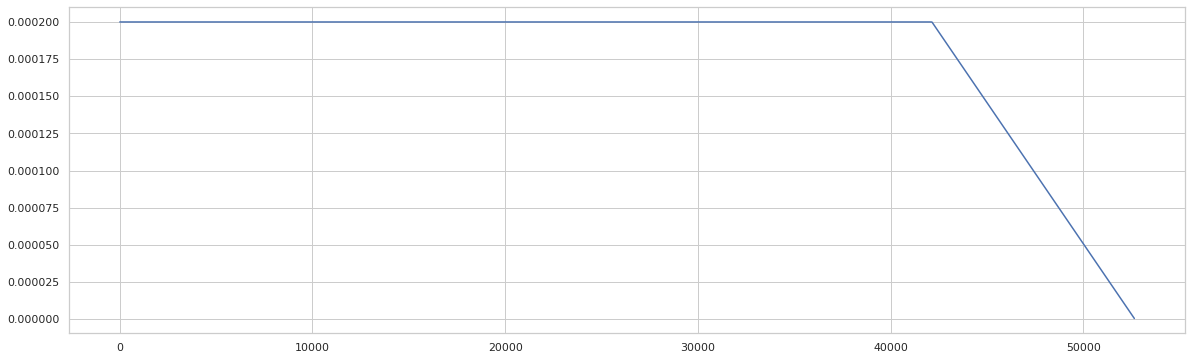

In [16]:
@tf.function
def linear_schedule_with_warmup(step):
    """ Create a schedule with a learning rate that decreases linearly after
    linearly increasing during a warmup period.
    """
    lr_start   = 2e-4
    lr_max     = 2e-4
    lr_min     = 0.
    
    steps_per_epoch = int(max(n_monet_samples, n_photo_samples)//BATCH_SIZE)
    total_steps = EPOCHS * steps_per_epoch
    warmup_steps = 1
    hold_max_steps = total_steps * 0.8
    
    if step < warmup_steps:
        lr = (lr_max - lr_start) / warmup_steps * step + lr_start
    elif step < warmup_steps + hold_max_steps:
        lr = lr_max
    else:
        lr = lr_max * ((total_steps - step) / (total_steps - warmup_steps - hold_max_steps))
        if lr_min is not None:
            lr = tf.math.maximum(lr_min, lr)

    return lr

steps_per_epoch = int(max(n_monet_samples, n_photo_samples)//BATCH_SIZE)
total_steps = EPOCHS * steps_per_epoch
rng = [i for i in range(0, total_steps, 50)]
y = [linear_schedule_with_warmup(x) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print(f'{EPOCHS} total epochs and {steps_per_epoch} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

## Train

In [17]:
with strategy.scope():
    # Create generators
    lr_monet_gen = lambda: linear_schedule_with_warmup(tf.cast(monet_generator_optimizer.iterations, tf.float32))
    lr_photo_gen = lambda: linear_schedule_with_warmup(tf.cast(photo_generator_optimizer.iterations, tf.float32))
    
    monet_generator_optimizer = optimizers.Adam(learning_rate=lr_monet_gen, beta_1=0.5)
    photo_generator_optimizer = optimizers.Adam(learning_rate=lr_photo_gen, beta_1=0.5)

    # Create discriminators
    lr_monet_disc = lambda: linear_schedule_with_warmup(tf.cast(monet_discriminator_optimizer.iterations, tf.float32))
    lr_photo_disc = lambda: linear_schedule_with_warmup(tf.cast(photo_discriminator_optimizer.iterations, tf.float32))
    
    monet_discriminator_optimizer = optimizers.Adam(learning_rate=lr_monet_disc, beta_1=0.5)
    photo_discriminator_optimizer = optimizers.Adam(learning_rate=lr_photo_disc, beta_1=0.5)

    
    # Create GAN
    gan_model = CycleGan(monet_generator, photo_generator, 
                         monet_discriminator, photo_discriminator)

    gan_model.compile(m_gen_optimizer=monet_generator_optimizer,
                      p_gen_optimizer=photo_generator_optimizer,
                      m_disc_optimizer=monet_discriminator_optimizer,
                      p_disc_optimizer=photo_discriminator_optimizer,
                      gen_loss_fn=generator_loss,
                      disc_loss_fn=discriminator_loss,
                      cycle_loss_fn=calc_cycle_loss,
                      identity_loss_fn=identity_loss)

In [18]:
photo_ds_eval = get_dataset(PHOTO_FILENAMES, repeat=False, shuffle=False, batch_size=1)
monet_ds_eval = get_dataset(MONET_FILENAMES, repeat=False, shuffle=False, batch_size=1)

# Callbacks
class GANMonitor(Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=1, monet_path='monet', photo_path='photo'):
        self.num_img = num_img
        self.monet_path = monet_path
        self.photo_path = photo_path
        # Create directories to save the generate images
        if not os.path.exists(self.monet_path):
            os.makedirs(self.monet_path)
        if not os.path.exists(self.photo_path):
            os.makedirs(self.photo_path)

    def on_epoch_begin(self, epoch, logs=None):
        # Monet generated images
        for i, img in enumerate(photo_ds_eval.take(self.num_img)):
            prediction = monet_generator(img, training=False)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            prediction = PIL.Image.fromarray(prediction)
            prediction.save(f'{self.monet_path}/generatedB_{i}_{epoch+1}.png')
            
        # Photo generated images
        for i, img in enumerate(monet_ds_eval.take(self.num_img)):
            prediction = photo_generator(img, training=False)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            prediction = PIL.Image.fromarray(prediction)
            prediction.save(f'{self.photo_path}/generatedB_{i}_{epoch+1}.png')
    
    def on_epoch_end(self, epoch, logs=None):
        # Monet generated images
        for i, img in enumerate(photo_ds_eval.take(self.num_img)):
            prediction = monet_generator(img, training=False)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            prediction = PIL.Image.fromarray(prediction)
            prediction.save(f'{self.monet_path}/generatedE_{i}_{epoch+1}.png')
            
        # Photo generated images
        for i, img in enumerate(monet_ds_eval.take(self.num_img)):
            prediction = photo_generator(img, training=False)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            prediction = PIL.Image.fromarray(prediction)
            prediction.save(f'{self.photo_path}/generatedE_{i}_{epoch+1}.png')

In [19]:
history = gan_model.fit(gan_ds, 
                        epochs=EPOCHS,
                        callbacks=[GANMonitor()],
                        steps_per_epoch=(max(n_monet_samples, n_photo_samples)//BATCH_SIZE), 
                        verbose=2).history

Epoch 1/120


2022-03-22 23:52:08.065404: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 8066, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647993128.062104922","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 8066, Output num: 0","grpc_status":3}


439/439 - 127s - monet_gen_loss: 2.7077 - photo_gen_loss: 3.0614 - monet_disc_loss: 0.5604 - photo_disc_loss: 0.7301


2022-03-22 23:54:15.442446: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 12304, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647993255.442342913","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 12304, Output num: 0","grpc_status":3}


Epoch 2/120
439/439 - 36s - monet_gen_loss: 2.4482 - photo_gen_loss: 2.1654 - monet_disc_loss: 0.6597 - photo_disc_loss: 0.6257
Epoch 3/120
439/439 - 36s - monet_gen_loss: 2.4100 - photo_gen_loss: 3.2506 - monet_disc_loss: 0.4872 - photo_disc_loss: 0.4395


2022-03-22 23:55:28.447381: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 15306, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647993328.447181853","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 15306, Output num: 0","grpc_status":3}


Epoch 4/120
439/439 - 36s - monet_gen_loss: 1.8727 - photo_gen_loss: 2.9805 - monet_disc_loss: 0.5917 - photo_disc_loss: 0.3185
Epoch 5/120
439/439 - 36s - monet_gen_loss: 2.0472 - photo_gen_loss: 2.7522 - monet_disc_loss: 0.5011 - photo_disc_loss: 0.4710


2022-03-22 23:56:41.505019: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 18308, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647993401.504952351","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 18308, Output num: 0","grpc_status":3}


Epoch 6/120
439/439 - 36s - monet_gen_loss: 2.5360 - photo_gen_loss: 2.3905 - monet_disc_loss: 0.8353 - photo_disc_loss: 1.0267
Epoch 7/120
439/439 - 36s - monet_gen_loss: 1.6020 - photo_gen_loss: 2.0446 - monet_disc_loss: 0.7335 - photo_disc_loss: 0.7383


2022-03-22 23:57:54.631647: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 21310, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647993474.631550712","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 21310, Output num: 0","grpc_status":3}


Epoch 8/120
439/439 - 36s - monet_gen_loss: 2.4010 - photo_gen_loss: 2.8299 - monet_disc_loss: 0.7031 - photo_disc_loss: 0.6804
Epoch 9/120
439/439 - 36s - monet_gen_loss: 2.1065 - photo_gen_loss: 2.4241 - monet_disc_loss: 0.7962 - photo_disc_loss: 0.6788


2022-03-22 23:59:07.620776: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 24312, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647993547.620672565","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 24312, Output num: 0","grpc_status":3}


Epoch 10/120
439/439 - 36s - monet_gen_loss: 2.5332 - photo_gen_loss: 2.3345 - monet_disc_loss: 0.7033 - photo_disc_loss: 0.4873
Epoch 11/120
439/439 - 36s - monet_gen_loss: 2.0075 - photo_gen_loss: 2.5230 - monet_disc_loss: 0.6278 - photo_disc_loss: 0.4407


2022-03-23 00:00:20.761924: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 27314, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647993620.761838755","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 27314, Output num: 0","grpc_status":3}


Epoch 12/120
439/439 - 36s - monet_gen_loss: 1.8888 - photo_gen_loss: 2.5725 - monet_disc_loss: 0.7316 - photo_disc_loss: 0.6185
Epoch 13/120
439/439 - 36s - monet_gen_loss: 2.2841 - photo_gen_loss: 2.4775 - monet_disc_loss: 0.5822 - photo_disc_loss: 0.4680


2022-03-23 00:01:33.823293: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 30316, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647993693.823121031","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 30316, Output num: 0","grpc_status":3}


Epoch 14/120
439/439 - 36s - monet_gen_loss: 2.1168 - photo_gen_loss: 2.5956 - monet_disc_loss: 0.6481 - photo_disc_loss: 0.7072
Epoch 15/120
439/439 - 36s - monet_gen_loss: 2.4953 - photo_gen_loss: 2.4497 - monet_disc_loss: 0.5671 - photo_disc_loss: 0.4308


2022-03-23 00:02:47.013415: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 33318, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647993767.013322197","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 33318, Output num: 0","grpc_status":3}


Epoch 16/120
439/439 - 36s - monet_gen_loss: 2.5851 - photo_gen_loss: 2.5272 - monet_disc_loss: 0.8294 - photo_disc_loss: 0.6073
Epoch 17/120
439/439 - 36s - monet_gen_loss: 1.9700 - photo_gen_loss: 2.0852 - monet_disc_loss: 0.7288 - photo_disc_loss: 0.7683


2022-03-23 00:04:00.225050: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 36320, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647993840.224997986","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 36320, Output num: 0","grpc_status":3}


Epoch 18/120
439/439 - 36s - monet_gen_loss: 2.5996 - photo_gen_loss: 2.2591 - monet_disc_loss: 0.4870 - photo_disc_loss: 0.6687
Epoch 19/120
439/439 - 36s - monet_gen_loss: 3.6341 - photo_gen_loss: 2.7518 - monet_disc_loss: 0.2757 - photo_disc_loss: 0.4741


2022-03-23 00:05:13.325437: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 39322, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647993913.325273665","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 39322, Output num: 0","grpc_status":3}


Epoch 20/120
439/439 - 36s - monet_gen_loss: 2.1713 - photo_gen_loss: 1.9701 - monet_disc_loss: 0.6737 - photo_disc_loss: 0.7833
Epoch 21/120
439/439 - 36s - monet_gen_loss: 3.2395 - photo_gen_loss: 3.2904 - monet_disc_loss: 0.5013 - photo_disc_loss: 0.4254


2022-03-23 00:06:26.474800: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 42324, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647993986.474701776","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 42324, Output num: 0","grpc_status":3}


Epoch 22/120
439/439 - 36s - monet_gen_loss: 2.4128 - photo_gen_loss: 2.8060 - monet_disc_loss: 0.4865 - photo_disc_loss: 0.3255
Epoch 23/120
439/439 - 36s - monet_gen_loss: 2.1672 - photo_gen_loss: 2.4025 - monet_disc_loss: 0.8173 - photo_disc_loss: 0.5077


2022-03-23 00:07:39.697543: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 45326, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647994059.697438194","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 45326, Output num: 0","grpc_status":3}


Epoch 24/120
439/439 - 36s - monet_gen_loss: 2.1358 - photo_gen_loss: 2.1259 - monet_disc_loss: 0.6134 - photo_disc_loss: 0.5857
Epoch 25/120
439/439 - 36s - monet_gen_loss: 2.6752 - photo_gen_loss: 2.8037 - monet_disc_loss: 0.5762 - photo_disc_loss: 0.6690


2022-03-23 00:08:52.937062: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 48328, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647994132.936952599","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 48328, Output num: 0","grpc_status":3}


Epoch 26/120
439/439 - 36s - monet_gen_loss: 2.3839 - photo_gen_loss: 2.1885 - monet_disc_loss: 0.5718 - photo_disc_loss: 0.6745
Epoch 27/120
439/439 - 36s - monet_gen_loss: 2.1830 - photo_gen_loss: 2.4169 - monet_disc_loss: 0.8424 - photo_disc_loss: 0.7364


2022-03-23 00:10:06.160304: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 51330, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647994206.160227771","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 51330, Output num: 0","grpc_status":3}


Epoch 28/120
439/439 - 36s - monet_gen_loss: 2.0939 - photo_gen_loss: 2.0704 - monet_disc_loss: 0.7407 - photo_disc_loss: 0.6027
Epoch 29/120
439/439 - 36s - monet_gen_loss: 2.5598 - photo_gen_loss: 2.3905 - monet_disc_loss: 0.6794 - photo_disc_loss: 0.6100


2022-03-23 00:11:19.420644: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 54332, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647994279.420554535","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 54332, Output num: 0","grpc_status":3}


Epoch 30/120
439/439 - 36s - monet_gen_loss: 2.4275 - photo_gen_loss: 2.3091 - monet_disc_loss: 0.5113 - photo_disc_loss: 0.7166
Epoch 31/120
439/439 - 36s - monet_gen_loss: 1.9437 - photo_gen_loss: 2.2961 - monet_disc_loss: 0.5867 - photo_disc_loss: 0.7237


2022-03-23 00:12:32.682242: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 57334, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647994352.682133298","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 57334, Output num: 0","grpc_status":3}


Epoch 32/120
439/439 - 36s - monet_gen_loss: 2.5062 - photo_gen_loss: 2.3623 - monet_disc_loss: 0.6796 - photo_disc_loss: 0.5848
Epoch 33/120
439/439 - 36s - monet_gen_loss: 2.5098 - photo_gen_loss: 2.6850 - monet_disc_loss: 0.5815 - photo_disc_loss: 0.5644


2022-03-23 00:13:45.918438: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 60336, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647994425.918362285","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 60336, Output num: 0","grpc_status":3}


Epoch 34/120
439/439 - 36s - monet_gen_loss: 2.2024 - photo_gen_loss: 2.4136 - monet_disc_loss: 0.5951 - photo_disc_loss: 0.5784
Epoch 35/120
439/439 - 36s - monet_gen_loss: 2.5555 - photo_gen_loss: 2.7794 - monet_disc_loss: 0.5226 - photo_disc_loss: 0.6601


2022-03-23 00:14:59.147946: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 63338, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647994499.147783894","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 63338, Output num: 0","grpc_status":3}


Epoch 36/120
439/439 - 36s - monet_gen_loss: 2.7248 - photo_gen_loss: 2.5133 - monet_disc_loss: 0.5320 - photo_disc_loss: 0.5764
Epoch 37/120
439/439 - 36s - monet_gen_loss: 1.8356 - photo_gen_loss: 2.1971 - monet_disc_loss: 0.9014 - photo_disc_loss: 0.6846


2022-03-23 00:16:12.376446: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 66340, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647994572.376332890","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 66340, Output num: 0","grpc_status":3}


Epoch 38/120
439/439 - 36s - monet_gen_loss: 2.7029 - photo_gen_loss: 2.8640 - monet_disc_loss: 0.4459 - photo_disc_loss: 0.4758
Epoch 39/120
439/439 - 36s - monet_gen_loss: 2.7228 - photo_gen_loss: 2.7659 - monet_disc_loss: 0.4673 - photo_disc_loss: 0.5868


2022-03-23 00:17:25.618621: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 69342, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647994645.618547986","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 69342, Output num: 0","grpc_status":3}


Epoch 40/120
439/439 - 36s - monet_gen_loss: 2.3185 - photo_gen_loss: 2.0683 - monet_disc_loss: 0.5681 - photo_disc_loss: 0.5046
Epoch 41/120
439/439 - 36s - monet_gen_loss: 2.9990 - photo_gen_loss: 2.8333 - monet_disc_loss: 0.6795 - photo_disc_loss: 0.7389


2022-03-23 00:18:38.870898: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 72344, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647994718.870805508","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 72344, Output num: 0","grpc_status":3}


Epoch 42/120
439/439 - 36s - monet_gen_loss: 2.0655 - photo_gen_loss: 2.5703 - monet_disc_loss: 0.5552 - photo_disc_loss: 0.5380
Epoch 43/120
439/439 - 36s - monet_gen_loss: 3.0721 - photo_gen_loss: 2.8282 - monet_disc_loss: 0.4394 - photo_disc_loss: 0.5415


2022-03-23 00:19:52.255632: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 75346, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647994792.255541218","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 75346, Output num: 0","grpc_status":3}


Epoch 44/120
439/439 - 36s - monet_gen_loss: 2.9105 - photo_gen_loss: 2.7303 - monet_disc_loss: 0.6631 - photo_disc_loss: 0.8226
Epoch 45/120
439/439 - 36s - monet_gen_loss: 1.9717 - photo_gen_loss: 2.1593 - monet_disc_loss: 0.7130 - photo_disc_loss: 0.6689


2022-03-23 00:21:05.601469: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 78348, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647994865.601414929","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 78348, Output num: 0","grpc_status":3}


Epoch 46/120
439/439 - 36s - monet_gen_loss: 2.4181 - photo_gen_loss: 2.2345 - monet_disc_loss: 0.4913 - photo_disc_loss: 0.8244
Epoch 47/120
439/439 - 36s - monet_gen_loss: 2.5152 - photo_gen_loss: 2.5362 - monet_disc_loss: 0.6324 - photo_disc_loss: 0.5471


2022-03-23 00:22:18.974952: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 81350, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647994938.974857945","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 81350, Output num: 0","grpc_status":3}


Epoch 48/120
439/439 - 36s - monet_gen_loss: 2.0980 - photo_gen_loss: 2.5906 - monet_disc_loss: 0.6674 - photo_disc_loss: 0.5591
Epoch 49/120
439/439 - 36s - monet_gen_loss: 2.2789 - photo_gen_loss: 2.1891 - monet_disc_loss: 0.6480 - photo_disc_loss: 0.8199


2022-03-23 00:23:32.390577: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 84352, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647995012.390492938","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 84352, Output num: 0","grpc_status":3}


Epoch 50/120
439/439 - 36s - monet_gen_loss: 2.3002 - photo_gen_loss: 2.2782 - monet_disc_loss: 0.6364 - photo_disc_loss: 0.5590
Epoch 51/120
439/439 - 36s - monet_gen_loss: 2.2402 - photo_gen_loss: 1.9378 - monet_disc_loss: 0.6020 - photo_disc_loss: 0.7664


2022-03-23 00:24:45.600416: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 87354, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647995085.600291816","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 87354, Output num: 0","grpc_status":3}


Epoch 52/120
439/439 - 36s - monet_gen_loss: 2.2031 - photo_gen_loss: 2.0191 - monet_disc_loss: 0.5622 - photo_disc_loss: 0.6494
Epoch 53/120
439/439 - 36s - monet_gen_loss: 2.1824 - photo_gen_loss: 1.9241 - monet_disc_loss: 0.5410 - photo_disc_loss: 0.7753


2022-03-23 00:25:58.858936: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 90356, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647995158.858877268","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 90356, Output num: 0","grpc_status":3}


Epoch 54/120
439/439 - 36s - monet_gen_loss: 2.1200 - photo_gen_loss: 2.3479 - monet_disc_loss: 0.5320 - photo_disc_loss: 0.5578
Epoch 55/120
439/439 - 36s - monet_gen_loss: 2.4755 - photo_gen_loss: 1.9241 - monet_disc_loss: 0.6822 - photo_disc_loss: 0.6755


2022-03-23 00:27:12.238187: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 93358, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647995232.237967184","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 93358, Output num: 0","grpc_status":3}


Epoch 56/120
439/439 - 36s - monet_gen_loss: 2.0654 - photo_gen_loss: 2.3873 - monet_disc_loss: 0.7323 - photo_disc_loss: 0.6728
Epoch 57/120
439/439 - 36s - monet_gen_loss: 2.0805 - photo_gen_loss: 1.9036 - monet_disc_loss: 0.6450 - photo_disc_loss: 0.5531


2022-03-23 00:28:25.698307: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 96360, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647995305.698235915","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 96360, Output num: 0","grpc_status":3}


Epoch 58/120
439/439 - 36s - monet_gen_loss: 1.9422 - photo_gen_loss: 2.0732 - monet_disc_loss: 0.7643 - photo_disc_loss: 0.6833
Epoch 59/120
439/439 - 36s - monet_gen_loss: 1.9051 - photo_gen_loss: 2.0705 - monet_disc_loss: 0.6615 - photo_disc_loss: 0.6045


2022-03-23 00:29:39.133086: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 99362, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647995379.133003645","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 99362, Output num: 0","grpc_status":3}


Epoch 60/120
439/439 - 36s - monet_gen_loss: 2.1152 - photo_gen_loss: 1.8908 - monet_disc_loss: 0.8725 - photo_disc_loss: 0.7146
Epoch 61/120
439/439 - 36s - monet_gen_loss: 1.7620 - photo_gen_loss: 2.2961 - monet_disc_loss: 0.7306 - photo_disc_loss: 0.7199


2022-03-23 00:30:52.531397: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 102364, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647995452.531300779","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 102364, Output num: 0","grpc_status":3}


Epoch 62/120
439/439 - 36s - monet_gen_loss: 1.7680 - photo_gen_loss: 2.1117 - monet_disc_loss: 0.6955 - photo_disc_loss: 0.4812
Epoch 63/120
439/439 - 36s - monet_gen_loss: 1.8492 - photo_gen_loss: 2.0489 - monet_disc_loss: 0.7701 - photo_disc_loss: 0.5826


2022-03-23 00:32:05.984344: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 105366, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647995525.984228430","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 105366, Output num: 0","grpc_status":3}


Epoch 64/120
439/439 - 36s - monet_gen_loss: 2.3223 - photo_gen_loss: 2.2380 - monet_disc_loss: 0.4012 - photo_disc_loss: 0.5444
Epoch 65/120
439/439 - 36s - monet_gen_loss: 3.4482 - photo_gen_loss: 2.4200 - monet_disc_loss: 0.5633 - photo_disc_loss: 0.7906


2022-03-23 00:33:19.382016: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 108368, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647995599.380157209","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 108368, Output num: 0","grpc_status":3}


Epoch 66/120
439/439 - 36s - monet_gen_loss: 2.7696 - photo_gen_loss: 2.2505 - monet_disc_loss: 0.3541 - photo_disc_loss: 0.6618
Epoch 67/120
439/439 - 36s - monet_gen_loss: 2.8432 - photo_gen_loss: 1.9324 - monet_disc_loss: 0.1896 - photo_disc_loss: 0.8100


2022-03-23 00:34:32.752691: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 111370, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647995672.752618114","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 111370, Output num: 0","grpc_status":3}


Epoch 68/120
439/439 - 36s - monet_gen_loss: 3.1980 - photo_gen_loss: 2.0763 - monet_disc_loss: 0.2295 - photo_disc_loss: 0.6313
Epoch 69/120
439/439 - 36s - monet_gen_loss: 2.3310 - photo_gen_loss: 2.1891 - monet_disc_loss: 0.6892 - photo_disc_loss: 0.5582


2022-03-23 00:35:46.081905: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 114372, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647995746.081617926","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 114372, Output num: 0","grpc_status":3}


Epoch 70/120
439/439 - 36s - monet_gen_loss: 2.5637 - photo_gen_loss: 1.6839 - monet_disc_loss: 0.5978 - photo_disc_loss: 0.6292
Epoch 71/120
439/439 - 36s - monet_gen_loss: 4.4682 - photo_gen_loss: 2.1399 - monet_disc_loss: 0.8991 - photo_disc_loss: 0.4023


2022-03-23 00:36:59.397583: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 117374, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647995819.397460561","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 117374, Output num: 0","grpc_status":3}


Epoch 72/120
439/439 - 36s - monet_gen_loss: 2.5596 - photo_gen_loss: 2.0856 - monet_disc_loss: 0.5440 - photo_disc_loss: 0.6213
Epoch 73/120
439/439 - 36s - monet_gen_loss: 2.5964 - photo_gen_loss: 2.2007 - monet_disc_loss: 0.4118 - photo_disc_loss: 0.4368


2022-03-23 00:38:12.838402: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 120376, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647995892.838317371","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 120376, Output num: 0","grpc_status":3}


Epoch 74/120
439/439 - 36s - monet_gen_loss: 3.0737 - photo_gen_loss: 2.3027 - monet_disc_loss: 0.3794 - photo_disc_loss: 0.5596
Epoch 75/120
439/439 - 36s - monet_gen_loss: 3.0158 - photo_gen_loss: 1.6617 - monet_disc_loss: 0.6273 - photo_disc_loss: 0.9185


2022-03-23 00:39:26.164132: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 123378, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647995966.164043958","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 123378, Output num: 0","grpc_status":3}


Epoch 76/120
439/439 - 36s - monet_gen_loss: 2.4351 - photo_gen_loss: 2.2479 - monet_disc_loss: 0.5140 - photo_disc_loss: 0.7733
Epoch 77/120
439/439 - 36s - monet_gen_loss: 2.9099 - photo_gen_loss: 2.1102 - monet_disc_loss: 0.5258 - photo_disc_loss: 0.6634


2022-03-23 00:40:39.556190: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 126380, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647996039.556102553","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 126380, Output num: 0","grpc_status":3}


Epoch 78/120
439/439 - 36s - monet_gen_loss: 4.1759 - photo_gen_loss: 2.3497 - monet_disc_loss: 0.1643 - photo_disc_loss: 0.7152
Epoch 79/120
439/439 - 36s - monet_gen_loss: 3.8773 - photo_gen_loss: 2.4675 - monet_disc_loss: 0.0999 - photo_disc_loss: 0.5564


2022-03-23 00:41:52.932109: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 129382, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647996112.932034743","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 129382, Output num: 0","grpc_status":3}


Epoch 80/120
439/439 - 36s - monet_gen_loss: 2.6071 - photo_gen_loss: 1.9090 - monet_disc_loss: 0.6623 - photo_disc_loss: 0.7001
Epoch 81/120
439/439 - 36s - monet_gen_loss: 2.3923 - photo_gen_loss: 2.0143 - monet_disc_loss: 0.6744 - photo_disc_loss: 0.4180


2022-03-23 00:43:06.289617: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 132384, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647996186.289474770","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 132384, Output num: 0","grpc_status":3}


Epoch 82/120
439/439 - 36s - monet_gen_loss: 4.2943 - photo_gen_loss: 2.4524 - monet_disc_loss: 0.1193 - photo_disc_loss: 0.5027
Epoch 83/120
439/439 - 36s - monet_gen_loss: 3.2523 - photo_gen_loss: 2.5147 - monet_disc_loss: 0.2255 - photo_disc_loss: 0.6234


2022-03-23 00:44:19.750246: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 135386, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647996259.750160484","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 135386, Output num: 0","grpc_status":3}


Epoch 84/120
439/439 - 36s - monet_gen_loss: 2.6310 - photo_gen_loss: 2.5901 - monet_disc_loss: 0.7115 - photo_disc_loss: 0.7121
Epoch 85/120
439/439 - 36s - monet_gen_loss: 2.6309 - photo_gen_loss: 2.0489 - monet_disc_loss: 0.4937 - photo_disc_loss: 0.6657


2022-03-23 00:45:33.190468: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 138388, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647996333.190389075","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 138388, Output num: 0","grpc_status":3}


Epoch 86/120
439/439 - 36s - monet_gen_loss: 2.9007 - photo_gen_loss: 2.5920 - monet_disc_loss: 0.3580 - photo_disc_loss: 0.4688
Epoch 87/120
439/439 - 36s - monet_gen_loss: 2.9318 - photo_gen_loss: 2.3769 - monet_disc_loss: 0.2361 - photo_disc_loss: 0.5921


2022-03-23 00:46:46.519071: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 141390, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647996406.518804996","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 141390, Output num: 0","grpc_status":3}


Epoch 88/120
439/439 - 36s - monet_gen_loss: 3.5737 - photo_gen_loss: 1.9355 - monet_disc_loss: 0.1702 - photo_disc_loss: 0.6364
Epoch 89/120
439/439 - 36s - monet_gen_loss: 3.4648 - photo_gen_loss: 2.4361 - monet_disc_loss: 0.2306 - photo_disc_loss: 0.5736


2022-03-23 00:47:59.991814: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 144392, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647996479.991747370","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 144392, Output num: 0","grpc_status":3}


Epoch 90/120
439/439 - 36s - monet_gen_loss: 2.9612 - photo_gen_loss: 2.3299 - monet_disc_loss: 0.3023 - photo_disc_loss: 0.4922
Epoch 91/120
439/439 - 36s - monet_gen_loss: 3.4032 - photo_gen_loss: 1.9580 - monet_disc_loss: 0.5004 - photo_disc_loss: 0.7010


2022-03-23 00:49:13.458854: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 147394, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647996553.458706555","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 147394, Output num: 0","grpc_status":3}


Epoch 92/120
439/439 - 36s - monet_gen_loss: 3.2713 - photo_gen_loss: 2.1437 - monet_disc_loss: 0.2687 - photo_disc_loss: 0.6705
Epoch 93/120
439/439 - 36s - monet_gen_loss: 2.6041 - photo_gen_loss: 2.0131 - monet_disc_loss: 0.5782 - photo_disc_loss: 0.6750


2022-03-23 00:50:26.965239: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 150396, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647996626.965141071","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 150396, Output num: 0","grpc_status":3}


Epoch 94/120
439/439 - 36s - monet_gen_loss: 2.1719 - photo_gen_loss: 2.2157 - monet_disc_loss: 0.4004 - photo_disc_loss: 0.4951
Epoch 95/120
439/439 - 36s - monet_gen_loss: 1.8245 - photo_gen_loss: 2.4432 - monet_disc_loss: 0.8997 - photo_disc_loss: 0.5552


2022-03-23 00:51:40.510803: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 153398, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647996700.510634637","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 153398, Output num: 0","grpc_status":3}


Epoch 96/120
439/439 - 36s - monet_gen_loss: 3.2211 - photo_gen_loss: 1.9579 - monet_disc_loss: 0.5820 - photo_disc_loss: 0.7541
Epoch 97/120
439/439 - 36s - monet_gen_loss: 2.6019 - photo_gen_loss: 2.4328 - monet_disc_loss: 0.4124 - photo_disc_loss: 0.4461


2022-03-23 00:52:54.059932: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 156400, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647996774.059837164","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 156400, Output num: 0","grpc_status":3}


Epoch 98/120
439/439 - 36s - monet_gen_loss: 3.1013 - photo_gen_loss: 2.6013 - monet_disc_loss: 0.2603 - photo_disc_loss: 0.5687
Epoch 99/120
439/439 - 36s - monet_gen_loss: 2.1056 - photo_gen_loss: 2.1330 - monet_disc_loss: 0.8273 - photo_disc_loss: 0.7557


2022-03-23 00:54:07.535909: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 159402, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647996847.535836489","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 159402, Output num: 0","grpc_status":3}


Epoch 100/120
439/439 - 36s - monet_gen_loss: 3.1971 - photo_gen_loss: 2.5917 - monet_disc_loss: 0.6040 - photo_disc_loss: 0.6157
Epoch 101/120
439/439 - 36s - monet_gen_loss: 2.8537 - photo_gen_loss: 2.2055 - monet_disc_loss: 0.5054 - photo_disc_loss: 0.7245


2022-03-23 00:55:20.990543: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 162404, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647996920.990431370","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 162404, Output num: 0","grpc_status":3}


Epoch 102/120
439/439 - 36s - monet_gen_loss: 3.4863 - photo_gen_loss: 2.2239 - monet_disc_loss: 0.5746 - photo_disc_loss: 0.7408
Epoch 103/120
439/439 - 36s - monet_gen_loss: 2.8930 - photo_gen_loss: 2.4748 - monet_disc_loss: 0.4601 - photo_disc_loss: 0.5224


2022-03-23 00:56:34.518324: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 165406, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647996994.518236567","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 165406, Output num: 0","grpc_status":3}


Epoch 104/120
439/439 - 36s - monet_gen_loss: 3.0986 - photo_gen_loss: 2.2502 - monet_disc_loss: 0.2638 - photo_disc_loss: 0.6720
Epoch 105/120
439/439 - 36s - monet_gen_loss: 3.6126 - photo_gen_loss: 2.4272 - monet_disc_loss: 0.5036 - photo_disc_loss: 0.5975


2022-03-23 00:57:47.886903: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 168408, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647997067.886791543","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 168408, Output num: 0","grpc_status":3}


Epoch 106/120
439/439 - 36s - monet_gen_loss: 2.8188 - photo_gen_loss: 2.5253 - monet_disc_loss: 0.2942 - photo_disc_loss: 0.4518
Epoch 107/120
439/439 - 36s - monet_gen_loss: 3.9823 - photo_gen_loss: 2.3522 - monet_disc_loss: 0.2431 - photo_disc_loss: 0.5404


2022-03-23 00:59:01.398093: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 171410, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647997141.398024574","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 171410, Output num: 0","grpc_status":3}


Epoch 108/120
439/439 - 36s - monet_gen_loss: 2.5945 - photo_gen_loss: 1.8298 - monet_disc_loss: 0.4592 - photo_disc_loss: 0.6195
Epoch 109/120
439/439 - 36s - monet_gen_loss: 3.2101 - photo_gen_loss: 1.9759 - monet_disc_loss: 0.2760 - photo_disc_loss: 0.5462


2022-03-23 01:00:14.932893: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 174412, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647997214.932803535","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 174412, Output num: 0","grpc_status":3}


Epoch 110/120
439/439 - 36s - monet_gen_loss: 2.1559 - photo_gen_loss: 2.2675 - monet_disc_loss: 0.6809 - photo_disc_loss: 0.7618
Epoch 111/120
439/439 - 36s - monet_gen_loss: 2.3924 - photo_gen_loss: 2.2036 - monet_disc_loss: 0.5582 - photo_disc_loss: 0.4204


2022-03-23 01:01:28.550021: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 177414, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647997288.549892387","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 177414, Output num: 0","grpc_status":3}


Epoch 112/120
439/439 - 36s - monet_gen_loss: 2.3694 - photo_gen_loss: 1.7449 - monet_disc_loss: 0.4609 - photo_disc_loss: 0.7766
Epoch 113/120
439/439 - 36s - monet_gen_loss: 2.5629 - photo_gen_loss: 2.2976 - monet_disc_loss: 0.3160 - photo_disc_loss: 0.5702


2022-03-23 01:02:42.148877: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 180416, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647997362.148768244","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 180416, Output num: 0","grpc_status":3}


Epoch 114/120
439/439 - 36s - monet_gen_loss: 2.4562 - photo_gen_loss: 2.2014 - monet_disc_loss: 0.3430 - photo_disc_loss: 0.6493
Epoch 115/120
439/439 - 36s - monet_gen_loss: 2.0716 - photo_gen_loss: 1.9916 - monet_disc_loss: 0.4939 - photo_disc_loss: 0.6455


2022-03-23 01:03:55.754780: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 183418, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647997435.754524318","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 183418, Output num: 0","grpc_status":3}


Epoch 116/120
439/439 - 36s - monet_gen_loss: 2.7597 - photo_gen_loss: 2.0176 - monet_disc_loss: 0.3404 - photo_disc_loss: 0.5676
Epoch 117/120
439/439 - 36s - monet_gen_loss: 3.0146 - photo_gen_loss: 2.0658 - monet_disc_loss: 0.3591 - photo_disc_loss: 0.7410


2022-03-23 01:05:09.343021: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 186420, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647997509.342901689","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 186420, Output num: 0","grpc_status":3}


Epoch 118/120
439/439 - 36s - monet_gen_loss: 2.8314 - photo_gen_loss: 1.8371 - monet_disc_loss: 0.4069 - photo_disc_loss: 0.5823
Epoch 119/120
439/439 - 36s - monet_gen_loss: 2.4430 - photo_gen_loss: 1.8397 - monet_disc_loss: 0.5587 - photo_disc_loss: 0.7516


2022-03-23 01:06:22.917672: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 189422, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647997582.917584024","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 189422, Output num: 0","grpc_status":3}


Epoch 120/120
439/439 - 36s - monet_gen_loss: 2.3784 - photo_gen_loss: 2.1914 - monet_disc_loss: 0.4104 - photo_disc_loss: 0.6264


## Create GIF Visualization

In [20]:
create_gif('/kaggle/working/monet/generatedB*.png', 'monet1.gif') # Create monet gif

In [21]:
create_gif('/kaggle/working/monet/generatedE*.png', 'monet2.gif') # Create monet gif

## Prediction

In [22]:
%%time
os.makedirs('../images/') # Create folder to save generated images
predict_and_save(photo_ds_eval, monet_generator, '../images/')

CPU times: user 9min 31s, sys: 3min 7s, total: 12min 39s
Wall time: 23min 21s


2022-03-23 01:31:00.046042: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 1788834, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1647999060.045827979","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 1788834, Output num: 0","grpc_status":3}


## Submission

In [23]:
shutil.make_archive('/kaggle/working/images/', 'zip', '../images')

print(f"Generated samples: {len([name for name in os.listdir('../images/') if os.path.isfile(os.path.join('../images/', name))])}")

Generated samples: 7038


## Save the H5 Models

In [24]:
monet_generator.save('monet_generator.h5')
photo_generator.save('photo_generator.h5')
monet_discriminator.save('monet_discriminator.h5')
photo_discriminator.save('photo_discriminator.h5')